# Recommendation system for products on an e-commerce website

Build your own recommendation system for products on an e-commerce website like Amazon.com

# Importing necessary packages

In [3]:
# basic packages
import pandas as pd
import numpy as np

# for plot
import matplotlib.pyplot as plt
import seaborn as sns

# plot style
plt.style.use("ggplot")

# for ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for inline plot
%matplotlib inline

# for Collaborative Filtering model
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader

# for splitting train / test data
from surprise.model_selection import train_test_split

# for creating defaultdict using surprise data
from collections import defaultdict

In [4]:
# setting column names for dataset
column_names = ['userId','productId','ratings','timestamp']

# reading dataset from standford.edu source, and setting column names
df = pd.read_csv('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv', names=column_names, header=None)
#df = pd.read_csv('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_All_Electronics.csv', names=column_names, header=None)


In [5]:
# checking basic details of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


We can drop 'timestamp' column, since its not require for this model

In [7]:
df.drop('timestamp', axis = 1, inplace=True)

In [8]:
df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Createing subset of the dataset to make it less sparse / denser

In [10]:
# getting user counts
counts = df['userId'].value_counts()

# creating new df using user counts, where user should rated at least 50 or above
new_df = df[df['userId'].isin(counts[counts >= 50].index)]

In [11]:
# checking null values
new_df.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [12]:
# checking data types
new_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [14]:
# checking new dataset basic info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
userId       125871 non-null object
productId    125871 non-null object
ratings      125871 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


In [13]:
# Unique Users and Products
print("Unique UserID count: %s" % str(new_df.userId.nunique()))
print("Unique ProductID count: %s" % str(new_df.productId.nunique()))

Unique UserID count: 1540
Unique ProductID count: 48190


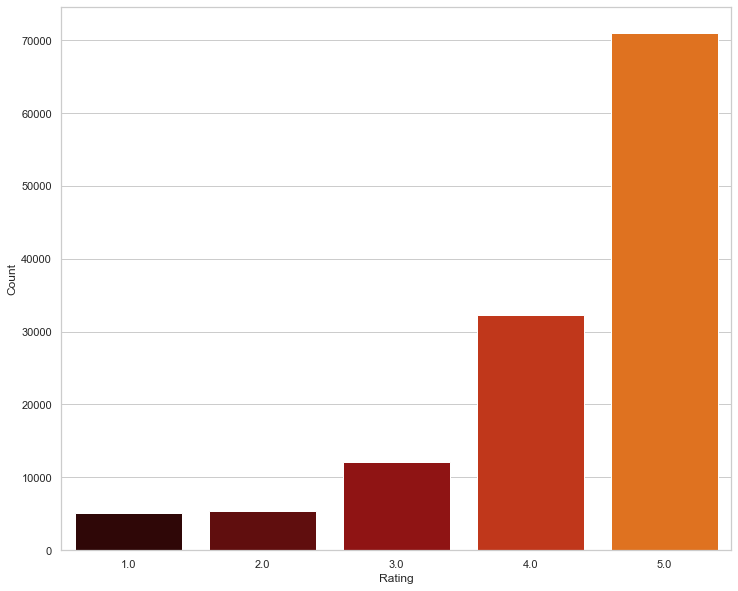

In [35]:
# Rating frequency
sns.set(rc={'figure.figsize': (12, 10)})
sns.set_style('whitegrid')
ax = sns.countplot(x='ratings', data=new_df, palette=sns.color_palette('gist_heat'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

70K+ ratings has been given as 5, which means more than 50% of the ratings are 5

In [16]:
# getting top rated users
user_ratings = pd.DataFrame(new_df.groupby('userId')['ratings'].count())
most_rated_user = user_ratings.sort_values('ratings', ascending=False)
most_rated_user.head(10)

,ratings
userId,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


In [17]:
# Mean rating for each Product

product_rating = new_df.groupby('productId')['ratings'].mean()
product_rating.head()

productId
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

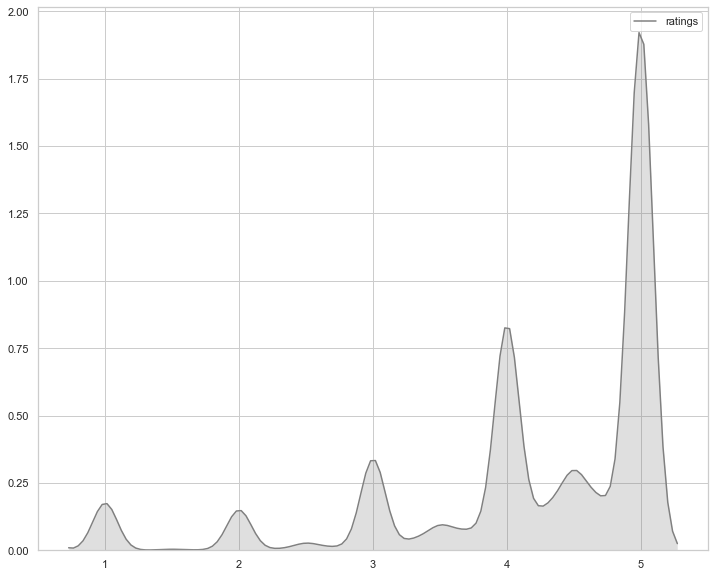

In [18]:
# Mean rating KDE distribution

ax = sns.kdeplot(product_rating, shade=True, color='grey')
plt.show()

In [19]:
# Count of the number of ratings per Product

product_rating_count = new_df.groupby('productId')['ratings'].count()
product_rating_count.head()

productId
0594451647    1
0594481813    1
0970407998    2
0972683275    4
1400501466    6
Name: ratings, dtype: int64

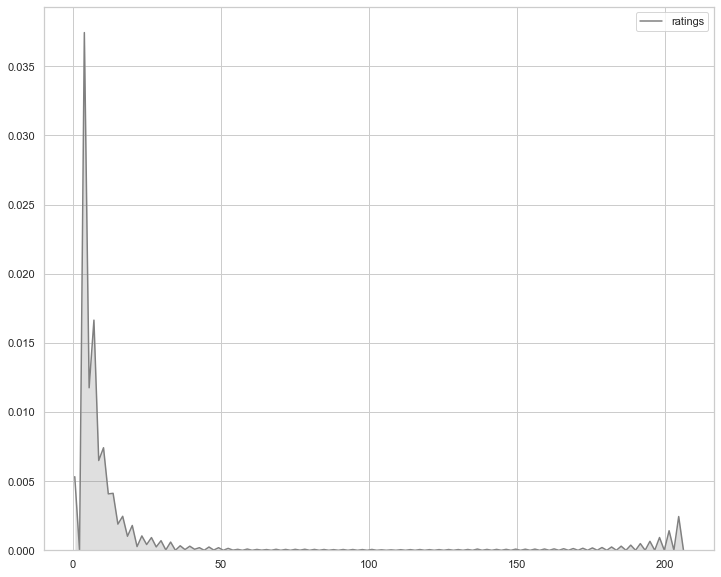

In [20]:
# Number of ratings per product KDE distribution

ax = sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

## Popularity Based Recommendation System

In [33]:
# getting popular products based on the rating counts
popular_products = pd.DataFrame(new_df.groupby('productId')['ratings'].count())
most_popular = popular_products.sort_values('ratings', ascending=False)
most_popular.head()

,ratings
productId,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149


These are the top 5 popular products, which will be recommend for all the users

### Visualize popular products based on the rating counts

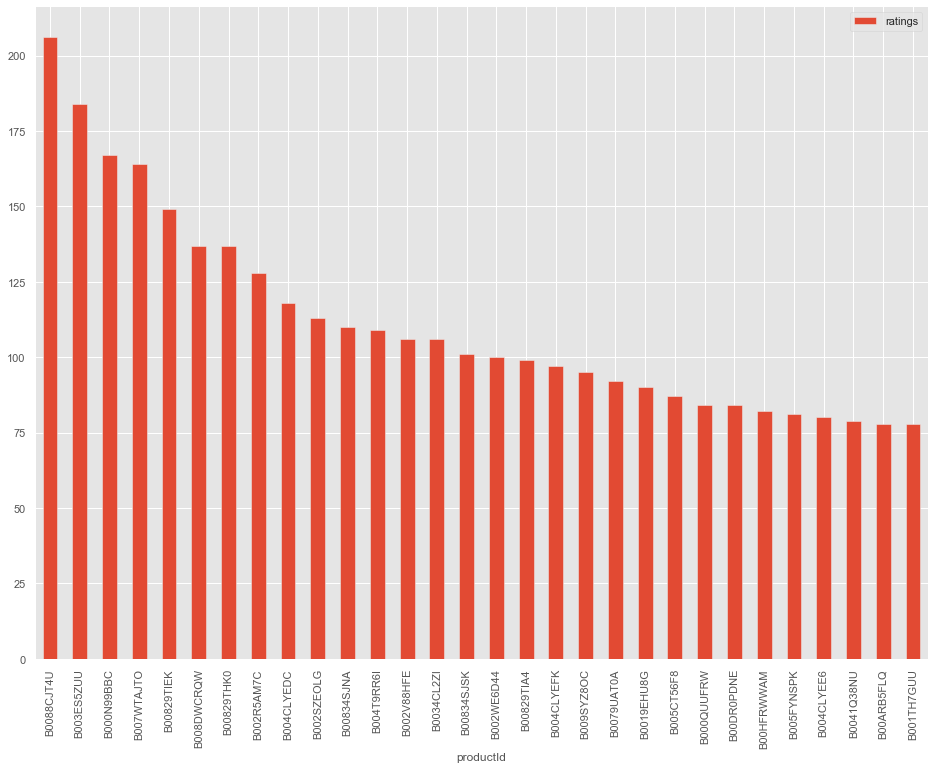

In [24]:
plt.style.use("ggplot")
most_popular.head(30).plot(kind = "bar",figsize=(16, 12))

## Collaborative Filtering Recommendation System

In [26]:
# creating reader for scale of 1 to 5
reader = Reader(rating_scale=(1, 5))

# using load_from_df function and reader for creating data
data = Dataset.load_from_df(new_df, reader)

# splitting data as train : test as ratio 70 : 30 respectively 
trainset, testset = train_test_split(data, test_size=.30)

In [27]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [28]:
# run the trained model against the testset
test_pred = algo.test(testset)

### Model Evaluation

In [38]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0603


1.0602845986799503

In [31]:
# function to get top recommenations from predictions dict 
def get_top_recommendations(predictions, topN=5):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
     
    return top_recs

## Top 5 recommendations for all users

In [36]:
top_5_prod_recom = get_top_recommendations(test_pred, 5)

In [37]:
top_5_prod_recom

defaultdict(list,
            {'ABXANRX4GPYRZ': [('B000I6P1I2', 4.314285714285714),
              ('B000OLDG60', 4.314285714285714),
              ('B0012MLJMI', 4.314285714285714),
              ('B000SATCUQ', 4.314285714285714),
              ('B000IV413S', 4.314285714285714)],
             'A3F7USIDJBR8WU': [('B00D9MCVOY', 4.478260869565218),
              ('B000F3H9UG', 4.478260869565218),
              ('B00BWLL9N8', 4.478260869565218),
              ('B00AWZFJ22', 4.478260869565218),
              ('B000UCAQ1G', 4.478260869565218)],
             'A34VRVI4CSI5RQ': [('B00CDS9HTM', 4.776508176844848),
              ('B00BWH7TIG', 4.752742946708464),
              ('B0044YU60M', 4.527093596059113),
              ('B00AR95ENW', 4.5176950998185115),
              ('B00HO5JE3I', 4.310344827586206)],
             'A20OBCQWBKCGZT': [('B00119T6NQ', 5),
              ('B0013IWYHU', 5),
              ('B0043M668G', 5),
              ('B00EUZV546', 4.983739837398375),
              ('B002JMYC

These are the top 5 recommendations for all the users

## Summary of Insights

### Data processing

<ol>
    <li>We have downloaded <b>7824482</b> records, we have removed <b>'timestamp'</b> column which is not required</li>
    <li>Its a huge data to process, so we have created a subset, using condition of user should be rated 50 or more products, now record size is <b>125871</b></li>
    <li>Unique UserID count: <b>1540</b>, Unique ProductID count: <b>48190</b></li>
    <li><b>Rating fequency:</b> 5 has been rated for more than 50% of records</li>
</ol>


### Popularity Based Recommendation System

Popularity based RS is getting from the popular products, which is always the same recommendation for all the users, since its related to product and not user specific


### Collaborative Filtering Recommendation System

KNNWithMeans is being used for Collaborative Filtering RS, and user_based = True, which means model is created user based recommendations. Recommendations will be based on the user we provide


### Model Evaluation

RMSE - Root Mean Square Error value is <b>1.0603</b> which is very good score